**Authors:** Anowar Shajib, David Law

*Adapted from the [notebook](https://github.com/JWST-Templates/Notebooks/blob/main/MIRI_MRS_reduction_SPT0418-47_PAH_ch3long.ipynb) by the TEMPLATES team (J. Spilker, K. A. Phadke, D. Law).*

In this notebook we process our data through the Spec2 pipeline in order to produce 
Lvl3 data products (i.e., calibrated slope images and quick-look data cubes and 1d 
spectra).  
    
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html

Here we'll run the Spec3 pipeline to produce a composite data cube from all dithered exposures.
We will need to create an association file from all science and background data in order for the pipeline to use them appropriately.


<div class="alert alert-block alert-warning">
A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html    
</div>

Spec3 requires an association file to be created to associate the individual _cal.fits science exposures together to be combined into a final combined data cube.

- If Master background subtraction was chosen, this will be applied during Spec3. Doing the Background subtraction requires the association file to be created to associate the background _x1d.fits files with all science files. For Master Background subtraction the association file must contain all _x1d.fits background files created with Spec2 and all _cal.fits science files to be combined into the final background subtracted science cube. 

The extract_1d step is controlled by a different set of parameters in the EXTRACT1D reference file.

For point sources:
>For point sources a circular extraction aperture is used, along with an optional circular annulus for background extraction and subtraction. The size of the extraction region and the background annulus size varies with wavelength. The extraction related vectors are found in the asdf extract1d reference file. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

For extended targets:
> For an extended source, rectangular aperture photometry is used, with the entire image being extracted, and no background subtraction, regardless of what was specified in the reference file or step arguments. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

from util import *

# JWST pipe version = 1.12.5
# STCAL version = 1.4.4


In [2]:
run_pipeline = True
subtract_combined_background = False

In [3]:
def write_to_association_file(
    science_files, background_files, association_file, product_name="Level3"
):
    """
    Write a .json association file that specifies a list of
    science and background exposures to be processed by Spec3.
    Note that any background exposures have to be of type x1d.

    :param science_files: List of science exposures to be processed
    :param association_file: Output .json file path/name
    :param product_name: AFAIK should just be 'Level3' always but prob
                      doesn't actually affect anything but metadata.
    :return: None
    :outputs: Writes a .json association file to the location in `asn_file'
    """
    # Define the basic association of science files
    association = asn_from_list(
        science_files, rule=DMS_Level3_Base, product_name=product_name
    )

    # Add background files to the association
    for background_file in background_files:
        association["products"][0]["members"].append(
            {"expname": background_file, "exptype": "background"}
        )

    # Write the association to a json file
    _, serialized = association.dump()
    with open(association_file, "w") as outfile:
        outfile.write(serialized)


def run_spec3_pipeline(association_file, output_directory):
    """
    Run the Spec3 pipeline using the given association file. The association
    file must contain the information needed - sci and bg cal files - to
    run the pipeline.

    :param association_file: file to run through the pipeline
    :param output_directory: Directory for the stage3 output files
    :return: None
    :outputs: Writes _cal.fits files for each exposure to `output_directory'. Also saves
              median-combined background images to `output_directory'. Additionally if
              nocubes=False, writes a 3D data cube built from each exposure
              to `output_directory'.
    """

    crds_config = Spec3Pipeline.get_config_from_reference(association_file)
    spec3 = Spec3Pipeline.from_config_section(crds_config)

    spec3.output_dir = output_directory
    spec3.save_results = True

    # Background overrides were set up above
    if subtract_combined_background:
        spec3.master_background.skip = False
    else:
        spec3.master_background.skip = True

    # Overrides for whether or not certain other steps should be skipped
    # spec3.assign_mtwcs.skip = False
    spec3.outlier_detection.skip = False
    # spec3.outlier_detection.kernel_size = '11 1'
    # spec3.outlier_detection.threshold_percent = 99.5 # Dial this threshold if necessary to be more/less aggressive in outlier flagging
    # spec3.mrs_imatch.skip = True
    # spec3.cube_build.skip = True
    # spec3.extract_1d.skip = False

    # Cube building configuration options
    # spec3.cube_build.override_cubepar = 'myfile.fits' # Cubepar parameter override
    # spec3.cube_build.output_file = 'mycube' # Custom output name
    # spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    # spec3.cube_build.channel = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
    # spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    # spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'
    # spec3.cube_build.scalexy = 0.5 # Output cube spaxel scale (arcsec) if setting it by hand
    # spec3.cube_build.scalew = 0.002 # Output cube voxel depth in wavelength if setting it by hand
    # spec3.cube_build.ra_center = 65.0 # Force cube to be centered at this R.A.
    # spec3.cube_build.dec_center = -35.0 # Force cube to be centered at this Decl.
    # spec3.cube_build.cube_pa = 45.0 # Force cube to have this position angle
    # spec3.cube_build.nspax_x = 61 # Require this number of spaxels in cube X direction
    # spec3.cube_build.nspax_y = 61 # Require this number of spaxels in cube Y direction
    # spec3.cube_build.wavemin = 4.8 # Custom minimum wavelength for the cube
    # spec3.cube_build.wavemax = 6.3 # Custom maximum wavelength for the cube

    # Extract1D overrides and config options
    # spec3.extract_1d.override_extract1d = 'myfile.asdf'
    # spec3.extract_1d.override_apcorr = 'myfile.asdf'
    # spec3.extract_1d.ifu_set_srctype = 'POINT' # Force a certain type of spectral extraction
    # spec3.extract_1d.ifu_rscale = 2 # Number of FWHM to use for point-source aperture extraction radius (default is 2)
    # spec3.extract_1d.ifu_autocen = True # Enable auto-centering of the extraction aperture
    # spec3.extract_1d.center_xy=(20,20) # Override aperture location if desired
    # spec3.extract_1d.ifu_rfcorr = True # Turn on 1d residual fringe correction

    spec3(association_file)

In [4]:
# Grab our lists of sci & background exposures.
# Note that since we did 2D bkg subtraction earlier we don't actually
# need these 1D backgrounds (they will be skipped by the Spec3 pipeline),
# but if you modified Spec2 to *not* do 2D subtraction, this would
# be how you would use them for a 1D master background subtraction here.
all_files = sorted(glob.glob(stage2_processed_directory + "jw*1001*cal.fits"))

science_files = all_files[:16]
background_files = all_files[16:]

# Make an association file that includes all of the different exposures
association_file = os.path.join(stage3_directory, "level3_asn.json")

write_to_association_file(science_files, background_files, association_file, "Level3")

if run_pipeline:
    run_spec3_pipeline(association_file, stage3_directory)

2023-12-17 04:46:22,335 - stpipe - WARNING - /Users/ajshajib/miniconda3/envs/jwst/lib/python3.9/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)

2023-12-17 04:46:22,702 - stpipe - WARNING - /Users/ajshajib/miniconda3/envs/jwst/lib/python3.9/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)

2023-12-17 04:46:25,304 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/ajshajib/Research/1131_JWST/CRDS/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0001.asdf
2023-12-17 04:46:25,319 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-12-17 04:46:25,320 - stpipe.Spec3Pipeline.assign_mtw

## Plot the spectra

Here we'll plot the spectra to see what our source looks like.

In [5]:
data, header = fits.getdata(
    stage3_directory + "Level3_g140m-f100lp_s3d.fits", header=True
)

In [6]:
data.shape

(1447, 79, 81)

2023-12-17 05:18:29,614 - stpipe - WARNING - /var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_2122/3201873453.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(np.nansum(data, axis=0)))



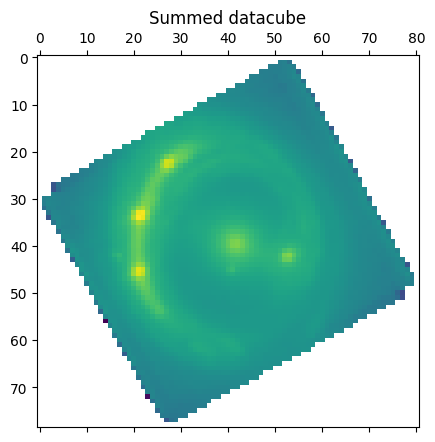

In [7]:
%matplotlib inline

plt.matshow(np.log10(np.nansum(data, axis=0)))
plt.title("Summed datacube")
plt.show()

2023-12-17 05:18:29,712 - stpipe - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


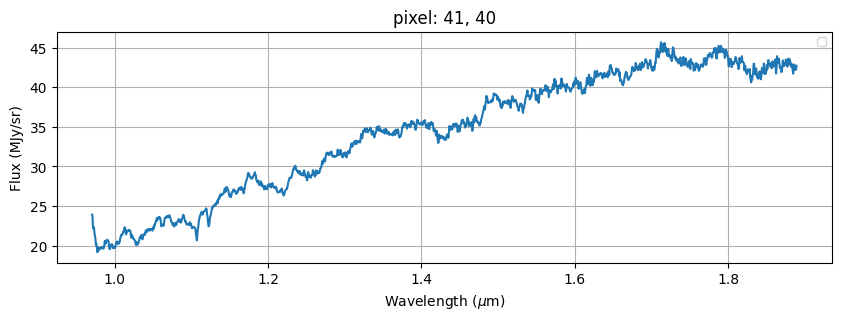

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

x_pix, y_pix = 41, 40
ymin, ymax = np.nan, np.nan

wavelength = header["CRVAL3"] + header["CDELT3"] * np.arange(header["NAXIS3"])
flux = data[:, y_pix, x_pix]

ymin = np.nanmin([ymin, np.nanpercentile(flux, 2)])
ymax = np.nanmax([ymax, np.nanpercentile(flux, 99.8)])

plt.plot(wavelength, flux)

plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(f"Flux ({header['BUNIT']})")
plt.title(f"pixel: {x_pix}, {y_pix}")
plt.legend(fontsize=8)
plt.grid()

In [9]:
# Use the finale extracted spectra (x1d.fits) files
x1d_file_path = stage3_directory + "*x1d.fits"
x1d_files = np.array(sorted(glob.glob(x1d_file_path)))

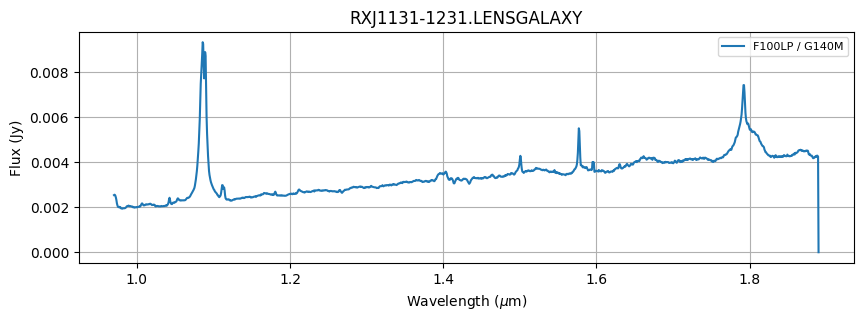

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

if len(x1d_files) > 0:
    hdu = fits.open(x1d_files[0])
    object_name = hdu[0].header["TARGPROP"]
else:
    object_name = "Unknown"

ymin, ymax = np.nan, np.nan

for file in x1d_files:
    x1d = fits.open(file)
    x1d_data = x1d[1].data
    wavelength = x1d_data["WAVELENGTH"]
    flux = x1d_data["FLUX"]
    ymin = np.nanmin([ymin, np.nanpercentile(flux, 2)])
    ymax = np.nanmax([ymax, np.nanpercentile(flux, 99.8)])

    # labels
    label = f"{x1d[0].header['FILTER']} / {x1d[0].header['GRATING']}"

    plt.plot(wavelength, flux, label=label)

plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel("Flux (Jy)")
plt.title(object_name)
# plt.ylim(ymin,ymax)
plt.legend(fontsize=8)
plt.grid()